In [48]:
%load_ext autoreload
%autoreload 2
import logging

logging.getLogger('mat73').setLevel(logging.CRITICAL)
import os
import re
from scipy.io import loadmat
import mat73
logging.getLogger('mat73').setLevel(logging.CRITICAL)

import warnings

from collections import Counter
import pandas as pd
import numpy as np
from scipy.stats import f_oneway, ttest_rel
from sklearn import linear_model

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from utils import *
from connectivity_dynamics import *
from eibal import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
## Plotting settings
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['axes.labelweight']
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams.update({'axes.titlesize': 'large'})
plt.rcParams['ytick.left'] = True
rc = {'figure.figsize':(5,5), 'ytick.left':True,'xtick.bottom':True ,
'xtick.major.size':8,
'xtick.major.width':4,
'xtick.minor.size':4,
'xtick.minor.width':4,
'xtick.labelsize':14,

'ytick.major.size':8,
'ytick.major.width':4,
'ytick.minor.size':4,
'ytick.minor.width':4,
'ytick.labelsize':14,

'font.sans-serif': "Arial",
"font.family":"sans-serif",
"axes.linewidth":10,
'font.weight': 'bold',
'figure.figsize':(4,8)
}

In [ ]:
# Changes between Periods for Net connectivity
stats_df = grp_df.dropna()

windows = stats_df.win_label.unique()
n = len(windows)
nz_sig_matrix = np.ones((n,n))
## do anova here 
for i, win_label in enumerate(windows):
    for j, comp_win in enumerate(windows):
        if i == j:
            continue
        win_df = stats_df[stats_df.win_label == win_label]
        comp_df = stats_df[stats_df.win_label == comp_win]
        nz_win = win_df.z_beta.values
        nz_comp = comp_df.z_beta.values   
        #Get net connectivity for each region during this window
        pval = ttest_ind(nz_win, nz_comp)[1]

        nz_sig_matrix[i,j] = pval
        print(f" {win_label} vs {comp_win} beta power is pval: {pval}")
    

#Setting multiple comparison cut off for significance result
cutoff = .05 / 5*5
#highlighting significant entries in the matrix 

print(f"\n\nNIZ SIG matrix values:\n {nz_sig_matrix}")
# nz_sig_matrix[nz_sig_matrix > cutoff] =1
# nz_sig_matrix[nz_sig_matrix <= cutoff] =0
nz_win_df = pd.DataFrame(data=1-nz_sig_matrix,columns=windows, index=windows)

 interictal vs pre-ictal beta power is pval: 3.8371157569343293e-16
 interictal vs early-ictal beta power is pval: 0.0
 interictal vs late_ictal beta power is pval: 0.0
 interictal vs post-ictal beta power is pval: 0.0
 pre-ictal vs interictal beta power is pval: 3.8371157569343293e-16
 pre-ictal vs early-ictal beta power is pval: 0.0
 pre-ictal vs late_ictal beta power is pval: 5.67792026509468e-299
 pre-ictal vs post-ictal beta power is pval: 0.0
 early-ictal vs interictal beta power is pval: 0.0
 early-ictal vs pre-ictal beta power is pval: 0.0
 early-ictal vs late_ictal beta power is pval: 0.8845766937244199
 early-ictal vs post-ictal beta power is pval: 0.0
 late_ictal vs interictal beta power is pval: 0.0
 late_ictal vs pre-ictal beta power is pval: 5.67792026509468e-299
 late_ictal vs early-ictal beta power is pval: 0.8845766937244199
 late_ictal vs post-ictal beta power is pval: 0.0
 post-ictal vs interictal beta power is pval: 0.0
 post-ictal vs pre-ictal beta power is pval: 0

# Loading Peri-Ictal PSDS
Here we will use the pre-computed spectral decompositions to plot the frequency range that most tracks E/I balance.
    According to the Voytek group this is the 30-50Hz range
    

In [3]:
DATA_DIR = '/mnt/ernie_main/Ghassan/ephys/data/ei_bal'

sub_paths= glob.glob(os.path.join(DATA_DIR, "*power*centered*"))
sub_paths

['/mnt/ernie_main/Ghassan/ephys/data/ei_bal/power_bal_Epat23_centered.csv',
 '/mnt/ernie_main/Ghassan/ephys/data/ei_bal/power_bal_Epat30_centered.csv',
 '/mnt/ernie_main/Ghassan/ephys/data/ei_bal/power_bal_Epat31_centered.csv',
 '/mnt/ernie_main/Ghassan/ephys/data/ei_bal/power_bal_Epat37_centered.csv',
 '/mnt/ernie_main/Ghassan/ephys/data/ei_bal/power_bal_Epat43_centered.csv',
 '/mnt/ernie_main/Ghassan/ephys/data/ei_bal/power_bal_Spat12_centered.csv',
 '/mnt/ernie_main/Ghassan/ephys/data/ei_bal/power_bal_Spat33_centered.csv',
 '/mnt/ernie_main/Ghassan/ephys/data/ei_bal/power_bal_Spat47_centered.csv',
 '/mnt/ernie_main/Ghassan/ephys/data/ei_bal/power_bal_Spat48_centered.csv',
 '/mnt/ernie_main/Ghassan/ephys/data/ei_bal/power_bal_Epat03_centered.csv',
 '/mnt/ernie_main/Ghassan/ephys/data/ei_bal/power_bal_Epat15_centered.csv',
 '/mnt/ernie_main/Ghassan/ephys/data/ei_bal/power_bal_Epat02_centered.csv',
 '/mnt/ernie_main/Ghassan/ephys/data/ei_bal/power_bal_Epat05_centered.csv',
 '/mnt/ernie

In [4]:
# subj_list = [m[0] for fname in sub_paths if (m := re.search("[A-Z]*pat[0-9]{1,2}", fname)) ]
# # m = re.search("[A-Z]pat[0-9]{1,2}", sub_paths[0])
# # m[0]
# subj_list_df = pd.DataFrame(data=subj_list)
# subj_list_df.to_csv("sublist.csv", index=False,header=False)

In [5]:
# subj_list_df = pd.read_csv('subjlist.csv',index_col=False,header=None)
# sub_list = [s[0] for s in subj_list_df.values]
# sub_list[0:1]

In [6]:
path = sub_paths[1]
print(f"Loading sub_path {path}")
tst_df = pd.read_csv(path)
# tst_df = center_onset(tst_df)
dfs = []
for f in sub_paths:
    dfs.append(pd.read_csv(f))
power_bal = pd.concat(dfs)

Loading sub_path /mnt/ernie_main/Ghassan/ephys/data/ei_bal/power_bal_Epat30_centered.csv


/tmp/ipykernel_27413/2647795713.py:7: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(f))
/tmp/ipykernel_27413/2647795713.py:7: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(f))
/tmp/ipykernel_27413/2647795713.py:7: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(f))
/tmp/ipykernel_27413/2647795713.py:7: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(f))
/tmp/ipykernel_27413/2647795713.py:7: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(f))
/tmp/ipykernel_27413/2647795713.py:7: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  dfs.append(pd.read_csv(f)

In [7]:
power_bal.head()


Unnamed: 0   win_label  win_sz_st_end  sz_end  win_sz_centered region  \
0           0  interictal         -595.0     389             -595    NIZ   
1           1  interictal         -595.0     389             -595    NIZ   
2           2  interictal         -595.0     389             -595    NIZ   
3           3  interictal         -595.0     389             -595    NIZ   
4           4  interictal         -595.0     389             -595    NIZ   

  eventID sz_type   patID     bip  ... period  window_designations  \
0      15     FAS  Epat23  LA1LA2  ...      0          0.0_0.0_0.0   
1      15     FAS  Epat23  LA2LA3  ...      0          0.0_0.0_0.0   
2      15     FAS  Epat23  LA3LA4  ...      0          0.0_0.0_0.0   
3      15     FAS  Epat23  LA4LA5  ...      0          0.0_0.0_0.0   
4      15     FAS  Epat23  LA5LA6  ...      0          0.0_0.0_0.0   

  power_delta   z_delta  frac_change_delta  power_beta    z_beta  \
0  -87.772905 -0.520261          -0.701431 -497.835244 -0.668167   
1  -96.281846  0.345665           0.469228 -513.836766 -0.844891   
2 -100.627333 -2.015651          -2.436612 -520.078074 -1.157925   
3  -98.956592 -0.060054          -0.080631 -519.538230 -0.976815   
4 -100.790885 -0.885055          -1.428565 -530.370544 -0.213042   

   frac_change_beta  Unnamed: 0.1  beta_involved  
0         -1.395240           NaN            NaN  
1         -0.999488           NaN            NaN  
2         -1.282574           NaN            NaN  
3         -0.887487           NaN            NaN  
4         -0.168508           NaN            NaN  

[5 rows x 21 columns]

# Peri Ictal Beta Power

In [8]:
cols = ['win_sz_st_end', 'region', 'patID', 'z_delta', 'z_beta']
group_cols = cols[0:-2]
power_bal = power_bal[power_bal.sz_type.isin(['FAS','FBTC','FIAS'])]
grp_df = power_bal[cols].groupby(group_cols).mean().reset_index()
grp_df.shape

(231610, 5)

## Statistics for Peri Ictal Beta Power

In [9]:
grp_df['win_label'] = grp_df.win_sz_st_end.apply(label_timestamp)
grp_df
    

win_sz_st_end region   patID   z_delta    z_beta   win_label
0              -595.0    NIZ  Epat02 -0.227357 -0.283873  interictal
1              -595.0    NIZ  Epat03 -0.243219  0.054217  interictal
2              -595.0    NIZ  Epat04  0.026390 -0.179733  interictal
3              -595.0    NIZ  Epat05  0.517637  0.191116  interictal
4              -595.0    NIZ  Epat06 -0.037094  0.676578  interictal
...               ...    ...     ...       ...       ...         ...
231605          623.0    SOZ  Spat51 -0.793470 -1.660265  post-ictal
231606          623.0    SOZ  Spat52  0.135553 -4.353485  post-ictal
231607          623.0    SOZ  Spat53  1.154076 -6.940278  post-ictal
231608          623.0    SOZ   pat11  0.118491 -0.258485  post-ictal
231609          623.0    SOZ   pat33  0.714750  0.410019  post-ictal

[231610 rows x 6 columns]

In [10]:
grp_df[grp_df.win_label.isna()].win_sz_st_end.unique()

array([], dtype=float64)

In [ ]:
# Changes between Periods for Net connectivity
stats_df = grp_df.dropna()

windows = stats_df.win_label.unique()
n = len(windows)
nz_sig_matrix = np.ones((n,n))
## do anova here 
for i, win_label in enumerate(windows):
    for j, comp_win in enumerate(windows):
        if i == j:
            continue
        win_df = stats_df[stats_df.win_label == win_label]
        comp_df = stats_df[stats_df.win_label == comp_win]
    
        nz_win = win_df.z_beta.values
        nz_comp = comp_df.z_beta.values   
        n = min(nz_win.shape[0], nz_comp.shape[0])
        m = max(nz_win.shape[0], nz_comp.shape[0])
        avg_ps = []
        print(f"Sizes of wins {n} and {m} permute: {m//n*10000}")
        for _ in range(m//n*10000):
            nz_win = np.random.choice(nz_win, n)
            nz_comp = np.random.choice(nz_comp, n)
            #Get net connectivity for each region during this window
            pval = ttest_rel(nz_win, nz_comp)[1]
            avg_ps.append(pval)
        avg_pval = np.mean(avg_ps)
        nz_sig_matrix[i,j] = avg_pval
        print(f" {win_label} vs {comp_win} beta power is pval: {avg_pval}")
    

#Setting multiple comparison cut off for significance result
cutoff = .05 / 5*5
#highlighting significant entries in the matrix 

print(f"\n\nNIZ SIG matrix values:\n {nz_sig_matrix}")
nz_sig_matrix[nz_sig_matrix > cutoff] =1
#nz_sig_matrix[nz_sig_matrix <= cutoff] =0
nz_win_df = pd.DataFrame(data=nz_sig_matrix,columns=windows, index=windows)

Sizes of wins 11280 and 100580 permute: 80000
 interictal vs pre-ictal beta power is pval: 0.018873430399742156
Sizes of wins 2820 and 100580 permute: 350000


/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)


 interictal vs early-ictal beta power is pval: 1.2080545434585598e-38
Sizes of wins 3008 and 100580 permute: 330000
 interictal vs late_ictal beta power is pval: 8.358868264676262e-39
Sizes of wins 100580 and 111484 permute: 10000
 interictal vs post-ictal beta power is pval: 0.0
Sizes of wins 11280 and 100580 permute: 80000
 pre-ictal vs interictal beta power is pval: 0.002740743648674616
Sizes of wins 2820 and 11280 permute: 40000
 pre-ictal vs early-ictal beta power is pval: 0.04060615323308298
Sizes of wins 3008 and 11280 permute: 30000
 pre-ictal vs late_ictal beta power is pval: 4.5791245560157614e-52
Sizes of wins 11280 and 111484 permute: 90000
 pre-ictal vs post-ictal beta power is pval: 0.0
Sizes of wins 2820 and 100580 permute: 350000
 early-ictal vs interictal beta power is pval: 3.9350329764558824e-62
Sizes of wins 2820 and 11280 permute: 40000
 early-ictal vs pre-ictal beta power is pval: 2.6506062152935815e-136
Sizes of wins 2820 and 3008 permute: 10000
 early-ictal vs l

In [54]:
cutoff = .05 / (5*5)
print(f"\n\nNIZ SIG matrix values with cutoff {cutoff}:\n {nz_sig_matrix}")
nz_sig_matrix[nz_sig_matrix > cutoff] =1
#nz_sig_matrix[nz_sig_matrix <= cutoff] =0
nz_win_df = pd.DataFrame(data=nz_sig_matrix,columns=windows, index=windows)



NIZ SIG matrix values with cutoff 0.002:
 [[1.00000000e+000 2.84623335e-002 4.11029715e-004 4.15625613e-041
  0.00000000e+000]
 [2.38447535e-002 1.00000000e+000 1.56226380e-136 8.56574795e-003
  0.00000000e+000]
 [1.71295673e-067 2.25002729e-143 1.00000000e+000 2.67729701e-003
  0.00000000e+000]
 [4.87420803e-004 2.83672179e-002 2.14173020e-002 1.00000000e+000
  3.28452364e-003]
 [0.00000000e+000 0.00000000e+000 0.00000000e+000 1.45353659e-151
  1.00000000e+000]]


## Plotting

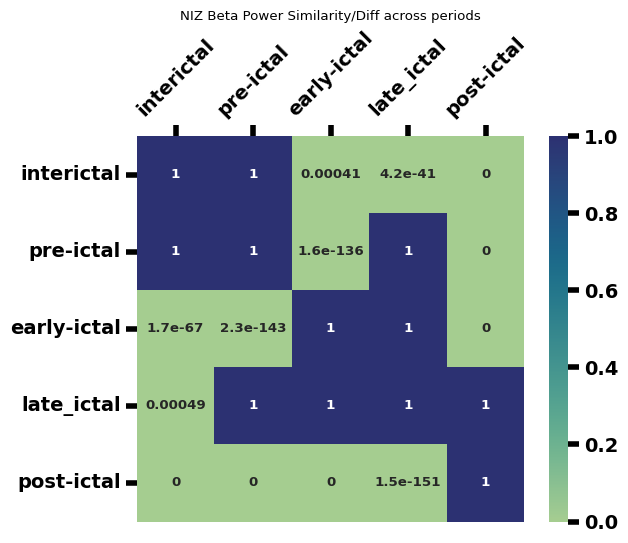

In [55]:
with sns.plotting_context("paper", rc=rc):
    ax = sns.heatmap(nz_win_df,annot=True,cmap="crest", annot_kws={"weight":"bold"})
    ax.xaxis.tick_top()
    plt.title("NIZ Beta Power Similarity/Diff across periods")
    plt.tight_layout()
    plt.xticks(rotation=45) 

    plt.savefig("../viz/interperiod_beta_diff.pdf",transparent=True)


In [12]:
## get time stamp of peri-ictal transition
tst_df = grp_df[grp_df.region == 'NIZ']
tst_df = tst_df[(tst_df.win_sz_st_end > 0) & (tst_df.win_sz_st_end < 30)]
tst_df = tst_df[['win_sz_st_end', 'z_beta']].groupby('win_sz_st_end').mean().reset_index()

In [13]:
# Get transition points
tst_df.diff()

win_sz_st_end    z_beta
0             NaN       NaN
1             1.0  0.183459
2             1.0  0.102361
3             1.0  0.049745
4             1.0 -0.034843
5             1.0 -0.060163
6             1.0 -0.000232
7             1.0  0.033018
8             1.0  0.038541
9             1.0  0.154805
10            1.0  1.127369
11            1.0  0.827916
12            1.0  0.839273
13            1.0  0.870369
14            1.0  1.065281
15            1.0  0.852669
16            1.0  0.278273
17            1.0 -0.316289
18            1.0 -1.206899
19            1.0 -1.049986
20            1.0 -0.228315
21            1.0 -0.496051
22            1.0 -0.245259
23            1.0 -0.337648
24            1.0 -0.496727
25            1.0 -0.711523
26            1.0 -1.052264
27            1.0 -2.093796
28            1.0 -4.086967

/tmp/ipykernel_27413/1332988873.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


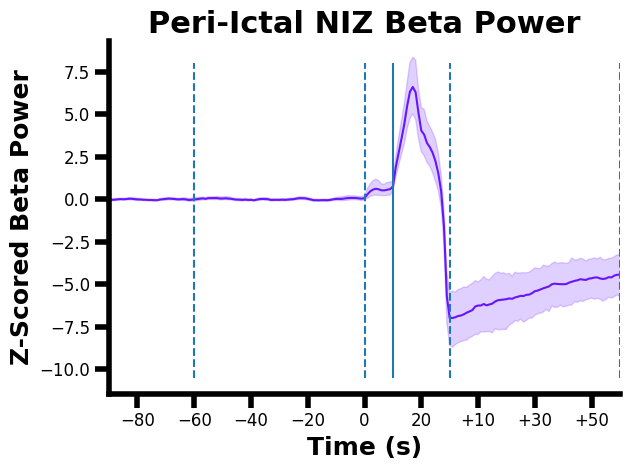

In [29]:
sns.set_style(rc=rc)
ax = sns.lineplot(grp_df[grp_df.region=='NIZ'], x='win_sz_st_end', y='z_beta', color='#6616FF')
ax.vlines(x = [-60,0, 30, 90], ymin = -10.5, ymax = 8,linestyles ='dashed')
ax.vlines(x = [10], ymin = -10.5, ymax = 8,linestyles ='solid')
#Title and labels

plt.title("Peri-Ictal NIZ Beta Power", weight='bold', fontsize=22)
plt.ylabel("Z-Scored Beta Power", weight='bold', fontsize= 18)
plt.xlabel("Time (s)", weight='bold', fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


# thicken axes lines
for axis in ['bottom','left']:
    ax.spines[axis].set_linewidth(4)
#Edit tick size, thickness, and labels
ax.tick_params(axis='both', which='major', labelsize=12, width=4, length=10)

plt.xlim(-90, 90)
# reset count to seizure end
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [f'+{str(int(l.replace("−","-")) -30)}' if int(l.replace("−", "-"))> 30 else l for l in labels]
ax.set_xticklabels(labels)
#last check to get everything bold
plt.rc("font", weight='bold')
plt.tight_layout()
plt.savefig("../viz/peri_ictalbeta_long.pdf", transparent=True)


## Seizure Subtyping

(-60.0, 90.0)

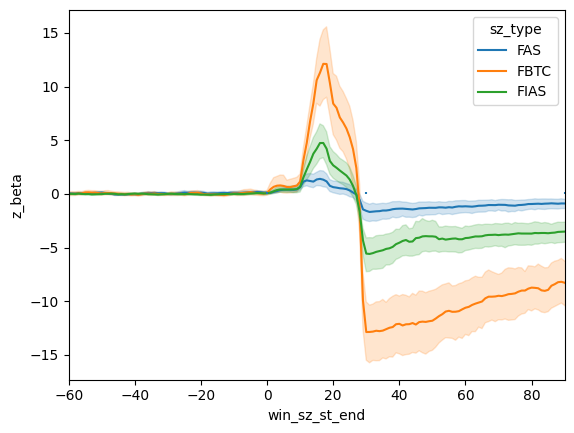

In [25]:

cols = ['win_sz_st_end', 'region', 'sz_type', 'patID', 'z_delta', 'z_beta']
group_cols = cols[0:-2]

plot_df = power_bal[cols].groupby(group_cols).mean().reset_index()
ax = sns.lineplot(plot_df[plot_df.region=='NIZ'], x='win_sz_st_end', y='z_beta', hue='sz_type')
ax.vlines(x = [-60,0, 30, 90], ymin = 0, ymax = .15,linestyles ='dashed')
plt.xlim(-60, 90)

(-30.0, 60.0)

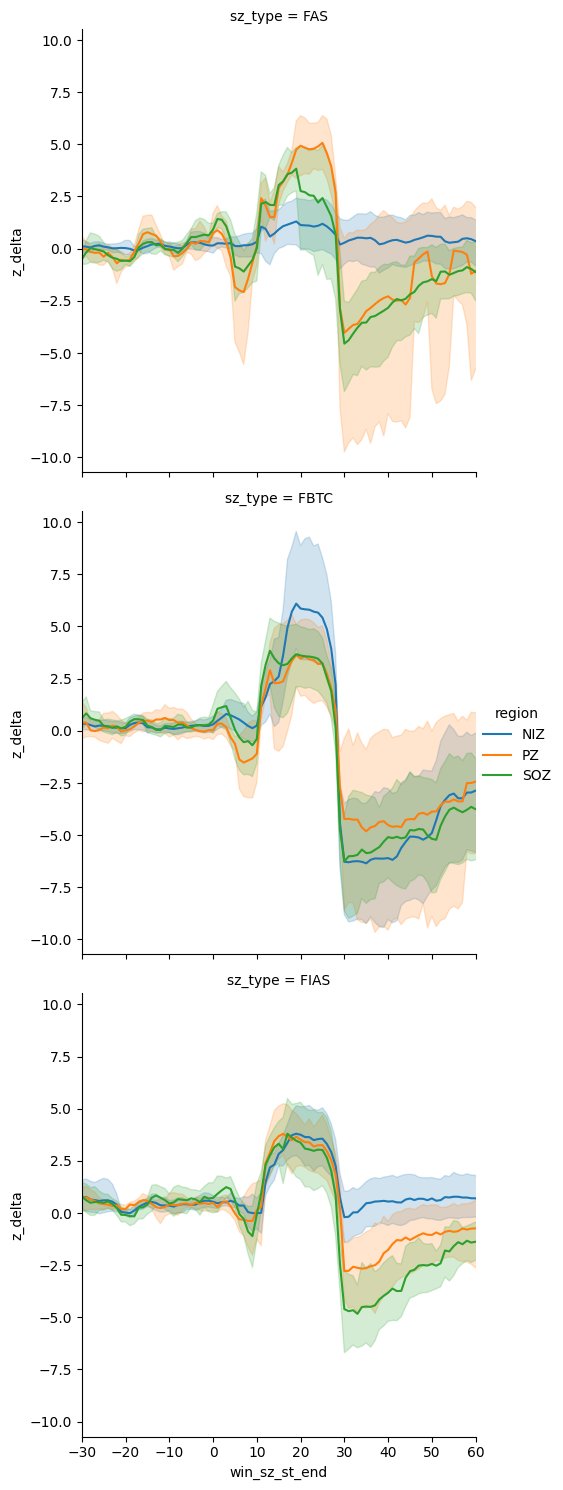

In [27]:
sns.relplot(grp_df,x='win_sz_st_end',y='z_delta',hue='region',row='sz_type',kind='line')
plt.xlim(-30,60)

(-10.0, 10.0)

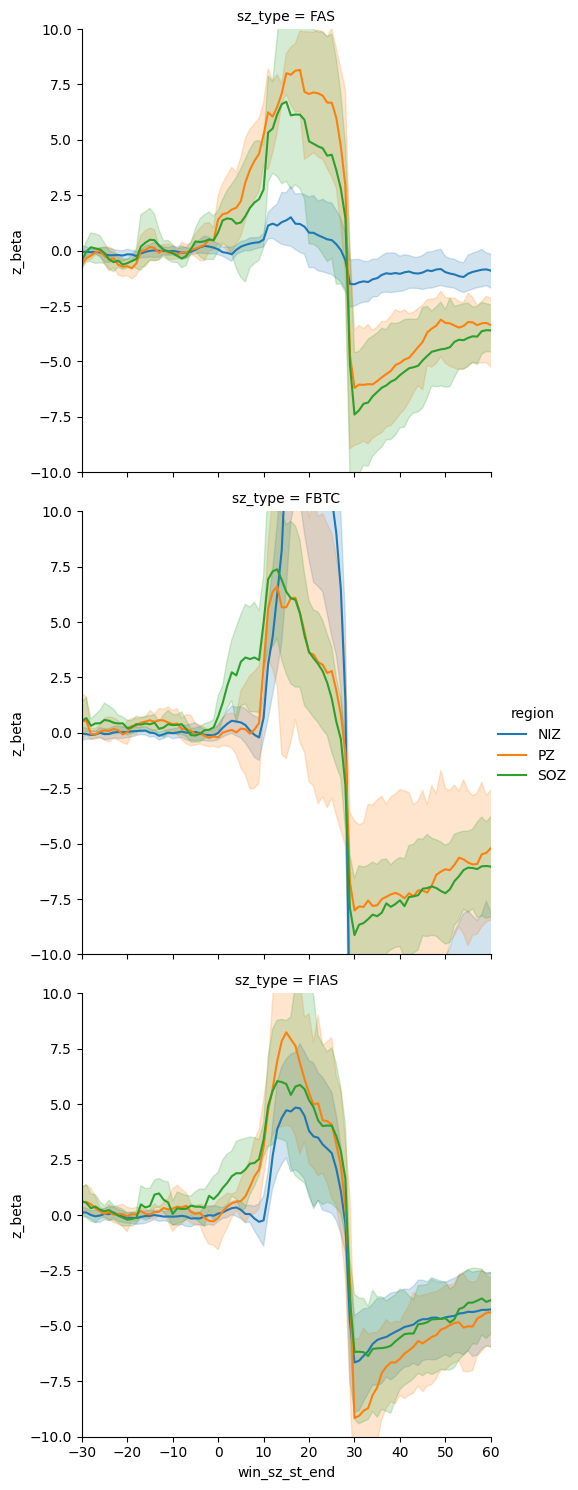

In [29]:
sns.relplot(grp_df,x='win_sz_st_end',y='z_beta',hue='region',row='sz_type',kind='line')
plt.xlim(-30,60)
plt.ylim(-10,10)

In [7]:
# grp_df = tst_df.groupby(['win_label','region'])
# count_df = grp_df.count()
# min_val = min(count_df.min().values)

# resamp_df = grp_df.sample(n=120, random_state=43)
# resamp_df.groupby(['win_label', 'region']).count()

# Assessing Seizure Involvement

In [10]:
# need to figure out how to determine what a significant increase in beta looks like.
# 1. Naive approach - use 2 std from mean values as the cutoff
# 2. Data driven approach - use statistics of the SOZ and PZ to determine SOZ sim (maybe a dot product of trajectories of z -scores or just making a threshold)
# for now, we start with quick n dirty

def get_involved_inds(event_df, band="beta", threshold=2):
    """Given an event_df, which contains the dynamics of all bipoles for one seizure event,
    thresholds all areas which achieve an average band power above threshold 
    and returns a column detailing which bipoles are involved as BANDS_increased"""
    ictal_df = event_df[event_df.win_label.isin(['early_ictal','ictal','late_ictal'])]
    ictal_bip_df = ictal_df[['bip', f'z_{band}',]].groupby('bip').mean().reset_index()
    # get regions with > threshold power
    thresh_bool = ictal_bip_df[f'z_{band}'].values > threshold
    power_dict = dict(zip(ictal_bip_df.bip, thresh_bool))
    all_bip_thresh = event_df.bip.apply(lambda x: power_dict[x])
    event_df.insert(loc=len(event_df.columns), column=f"{band}_involved", value=all_bip_thresh)
    return event_df
event_df = tst_df[tst_df.eventID == '11']
event_df = get_involved_inds(event_df)
event_df.head(5)

win_label  win_sz_st_end  sz_end  win_sz_centered region eventID sz_type  \
0  interictal           -595     240             -595    NIZ      11    FIAS   
1  interictal           -595     240             -595    NIZ      11    FIAS   
2  interictal           -595     240             -595    NIZ      11    FIAS   
3  interictal           -595     240             -595    NIZ      11    FIAS   
4  interictal           -595     240             -595    NIZ      11    FIAS   

    patID     bip              anat_region  period window_designations  \
0  Epat14  RH1RH2        Right-Hippocampus       0         0.0_0.0_0.0   
1  Epat14  RH2RH3        Right-Hippocampus       0         0.0_0.0_0.0   
2  Epat14  RH3RH4        Right-Hippocampus       0         0.0_0.0_0.0   
3  Epat14  RH4RH5        Right-Hippocampus       0         0.0_0.0_0.0   
4  Epat14  RH8RH9  ctx-rh-superiortemporal       0         0.0_0.0_0.0   

   power_delta   z_delta  frac_change_delta  power_beta    z_beta  \
0   -96.464794 -0.072691          -0.157794 -505.559482 -1.556853   
1   -96.855669 -0.745006          -1.337569 -494.716724 -1.060611   
2   -93.435015 -0.439157          -1.016337 -488.854015  0.365354   
3   -98.005805 -0.470616          -0.912272 -497.864082 -1.057288   
4  -103.817442 -0.323043          -0.460086 -517.490418 -0.223430   

   frac_change_beta  beta_involved  
0         -0.973672          False  
1         -0.532486          False  
2          0.209371           True  
3         -0.540843          False  
4         -0.131329          False

In [44]:
# Get regions involved
involved_bips = dict(zip(event_df.bip, event_df.beta_involved))


In [45]:
f_path = '/mnt/ernie_main/Price/ephys/data/periconnectivity'
patID = 'Epat04'
glob.glob(os.path.join(f_path, f"peri_ictal_flow_verbose_{patID}.csv"))


['/mnt/ernie_main/Price/ephys/data/periconnectivity/peri_ictal_flow_verbose_Epat04.csv']

In [46]:
#load an example bipole level flow DF
flow_df = pd.read_csv('/mnt/ernie_main/Price/ephys/data/periconnectivity/peri_ictal_flow_verbose_Epat04.csv')
flow_df = flow_df[flow_df.eventID ==14]
flow_df = center_onset(flow_df)
# Map bipoles involved in Seizure onsete 
# reg_involved = [f"{row['source']}_{row['target']}_{involved_bips[row['src_bip']]}" for _, row in flow_df.iterrows()]
# flow_df['ictal_involvement']= reg_involved


In [47]:
plot_df = event_df[['bip','z_beta','win_sz_centered' ,'beta_involved']].merge(flow_df,how='right',right_on=['win_sz_centered','src_bip'], left_on=['win_sz_centered','bip'])
plot_df['region_involved'] = plot_df.apply( \
    lambda x: f"{x['source']}_{x['target']}_{x['beta_involved']}",\
    axis=1)

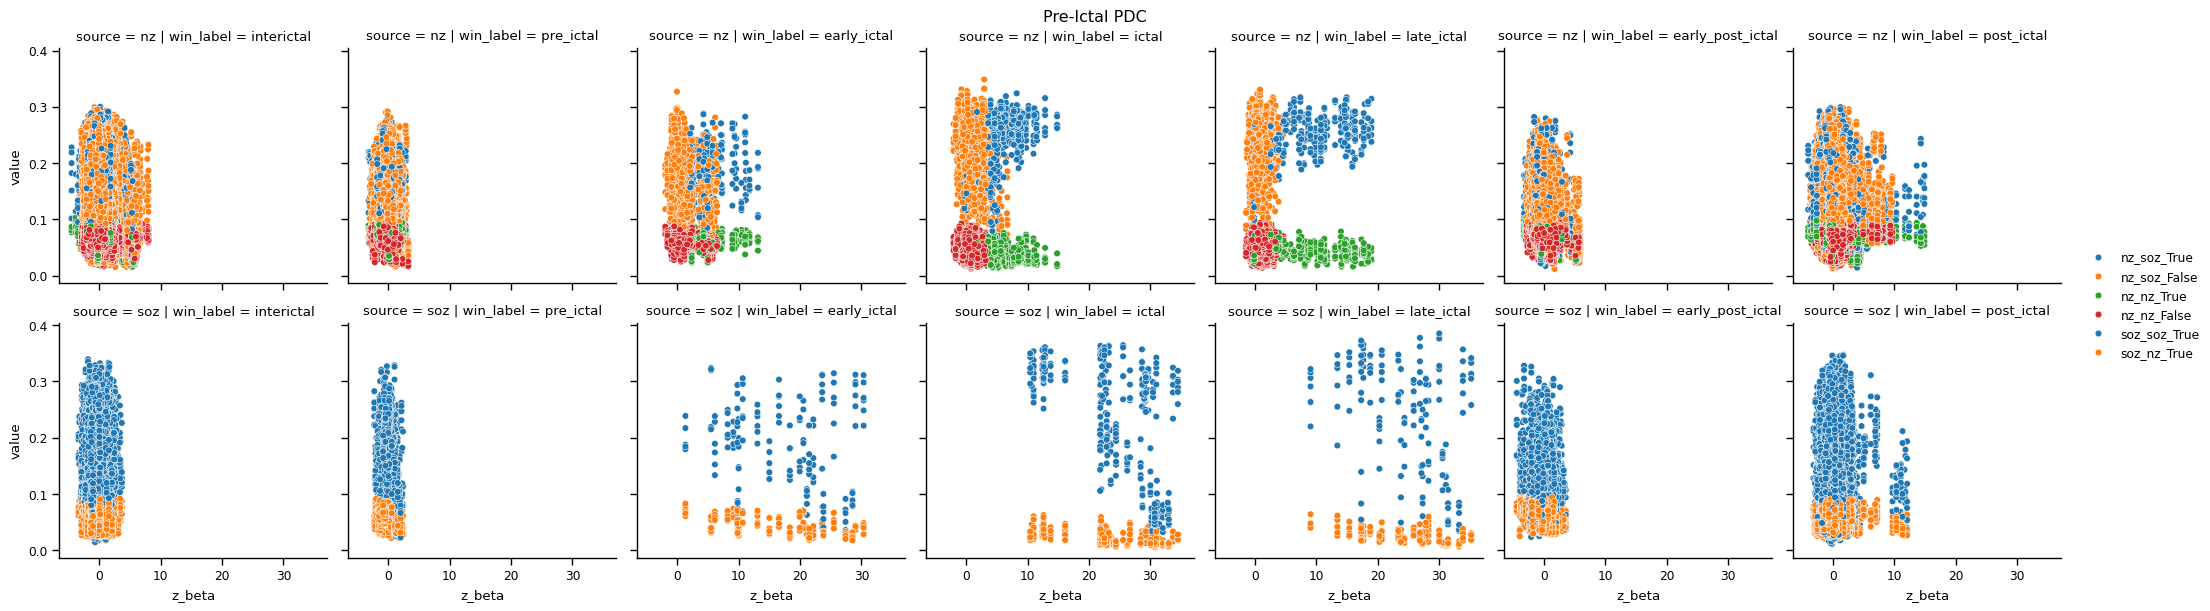

In [49]:

with sns.plotting_context("paper"):
        grid = sns.FacetGrid(plot_df, row='source',row_order=['nz','soz'],
                             col='win_label', 
                             col_order=['interictal', 'pre_ictal','early_ictal','ictal','late_ictal','early_post_ictal','post_ictal'],
                             ) 
        ax = grid.map_dataframe(sns.scatterplot, y='value',x='z_beta', hue='region_involved')
        grid.add_legend()
        grid.figure.suptitle("Pre-Ictal PDC",y=1.01)
        plt.savefig("../viz/peri_ictal_beta_flow_corr.pdf", transparent=True)

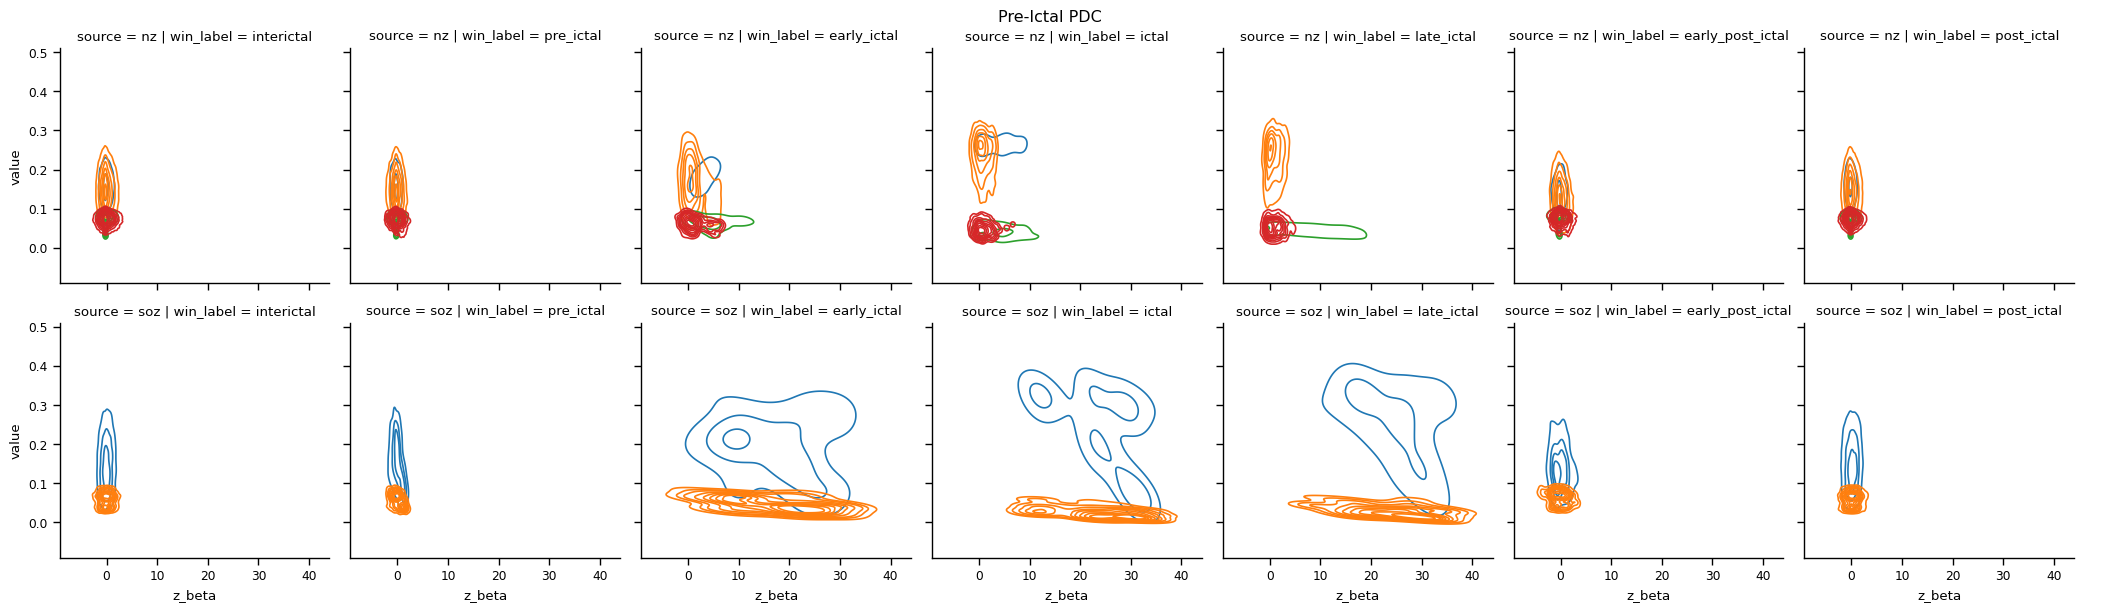

In [51]:

with sns.plotting_context("paper"):
        grid = sns.FacetGrid(plot_df, row='source',row_order=['nz','soz'],
                             col='win_label', 
                             col_order=['interictal', 'pre_ictal','early_ictal','ictal','late_ictal','early_post_ictal','post_ictal'],
                             ) 
        ax = grid.map_dataframe(sns.kdeplot, y='value',x='z_beta', hue='region_involved')
        grid.add_legend()
        grid.figure.suptitle("Pre-Ictal PDC",y=1.01)
        plt.savefig("../viz/peri_ictal_beta_flow_corr.pdf", transparent=True)

In [21]:
x
y

array([], shape=(0, 1), dtype=float64)

In [27]:
#Get correlations for a given event over several windows
def beta_flow_to_corr_df(beta_flow_df):
    """Given a merged dataframe containing values of flow at the bipole level, and 
    beta values at the bipole level, which has also been centered. Returns 
    a summary of the correlations between beta power and the flow values from
    all source target combinations across all periods.

    #TODO: make general to all power bands
    #TODO check assumptions of columns and centering
    #TODO ensure that each df is ONLY ONE EVENT with assumptions checking 
    
    Args:
        beta_flow_df (pd.DataFrame): merged dataframe that has been centered. Should contain
        bipole level connectivity (flow) and bipole level beta power


    Returns:
        _type_: _description_
    """
    eventID = beta_flow_df.eventID.values[0]
    patID = beta_flow_df.patID.values[0]
    sz_type = beta_flow_df.sz_type.values[0]
    corr_dict = defaultdict(lambda: [])
    for src in ['nz','pz', 'soz']:
        for win_label in set(plot_df.win_label):
            for ictal_rating in set(plot_df.ictal_involvement):
                df = plot_df[plot_df.source == src]
                df = df[df.win_label==win_label]
                df = df[df.ictal_involvement == ictal_rating]
                x = np.expand_dims(df.z_beta.values, axis=1)
                y = np.expand_dims(df.value.values, axis=1)
                if x.shape[0] < 2:
                    continue
                regr = linear_model.LinearRegression()
                regr.fit(x,y)
                coeff = regr.coef_[0][0]
                corr_dict['source'].append(src)
                corr_dict['period'].append(win_label)
                corr_dict['ictal_involvement'].append(ictal_rating)
                corr_dict["corr_coeff"].append(coeff)
                corr_dict['patID'].append(patID)
                corr_dict['eventID'].append(eventID)
                corr_dict['sz_type'].append(sz_type)
    corr_df = pd.DataFrame.from_dict(corr_dict)
    return corr_df

In [26]:
corr_df = pd.DataFrame.from_dict(corr_dict)
corr_df

source            period ictal_involvement                 corr_coeff
0      nz        late_ictal       nz_nz_False   [-7.400662309491197e-06]
1      nz        late_ictal      nz_soz_False    [0.0034614408474667713]
2      nz        late_ictal        nz_nz_True   [-0.0007087899081562769]
3      nz        late_ictal       nz_soz_True     [0.002959728706755115]
4      nz  early_post_ictal       nz_nz_False   [-0.0013935124376321004]
5      nz  early_post_ictal      nz_soz_False    [-0.005813571740765166]
6      nz  early_post_ictal        nz_nz_True    [-0.002146145138658456]
7      nz  early_post_ictal       nz_soz_True   [-0.0023741770260148174]
8      nz         pre_ictal       nz_nz_False    [-0.002139485353647501]
9      nz         pre_ictal      nz_soz_False   [-0.0036480506048156103]
10     nz         pre_ictal        nz_nz_True   [0.00010486463448625145]
11     nz         pre_ictal       nz_soz_True    [-0.001370601397745217]
12     nz       early_ictal       nz_nz_False    [-0.002005135839983483]
13     nz       early_ictal      nz_soz_False   [-0.0068343466957562484]
14     nz       early_ictal        nz_nz_True   [-0.0005639325073179743]
15     nz       early_ictal       nz_soz_True    [0.0028484768973871086]
16     nz        interictal       nz_nz_False    [-0.000589642460843065]
17     nz        interictal      nz_soz_False   [-0.0027776126118788727]
18     nz        interictal        nz_nz_True   [-0.0006196826264752012]
19     nz        interictal       nz_soz_True   [-0.0019461690356375155]
20     nz             ictal       nz_nz_False    [-0.000802922255503989]
21     nz             ictal      nz_soz_False     [-0.00706390203706051]
22     nz             ictal        nz_nz_True   [-0.0006751796052185556]
23     nz             ictal       nz_soz_True    [0.0023897647206190266]
24     nz        post_ictal       nz_nz_False   [-0.0001532300114379317]
25     nz        post_ictal      nz_soz_False    [-0.001301282166069654]
26     nz        post_ictal        nz_nz_True  [-0.00034202713938058396]
27     nz        post_ictal       nz_soz_True    [-0.001583614738960818]
28    soz        late_ictal       soz_nz_True   [-0.0009670295345892534]
29    soz        late_ictal      soz_soz_True    [-0.005240623827771542]
30    soz  early_post_ictal       soz_nz_True    [-0.001891825053888399]
31    soz  early_post_ictal      soz_soz_True     [-0.00513711296591384]
32    soz         pre_ictal       soz_nz_True    [-0.007381040555150407]
33    soz         pre_ictal      soz_soz_True    [-0.026747276013882826]
34    soz       early_ictal       soz_nz_True   [-0.0010484795889677569]
35    soz       early_ictal      soz_soz_True   [-0.0012441552842349407]
36    soz        interictal       soz_nz_True    [0.0002281470519108839]
37    soz        interictal      soz_soz_True    [0.0020156243017231275]
38    soz             ictal       soz_nz_True   [-0.0008649112159817197]
39    soz             ictal      soz_soz_True    [-0.008014094716638397]
40    soz        post_ictal       soz_nz_True   [1.2737398302834103e-05]
41    soz        post_ictal      soz_soz_True    [0.0013645447958998288]

<Axes: xlabel='period', ylabel='value'>

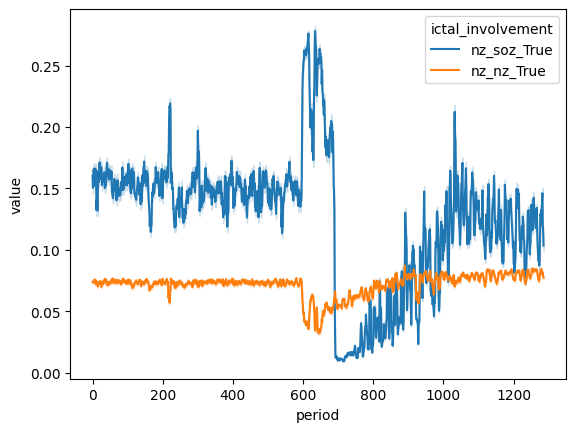

In [91]:
df = flow_df[flow_df.source == 'nz']
sns.lineplot(data=df, hue='ictal_involvement', x='period', y='value')#,palette=COLOR_MAP)


In [39]:
#Setup for power analysis

# bip = get_chan_names(tst_struct)
# pwelch_all_windows = read_conn_struct(tst_struct, 'pdc','pwelch_all_windowed')
# window_dict = prep_window_dict(tst_struct)
# freqs = read_conn_struct(tst_struct, 'pdc','pwelch_freqs')

# soz_per_szr = read_conn_struct(tst_struct, 'pdc', 'soz_per_seizure')
# contact_label = format_soz(soz_per_szr)


In [40]:
# Plot PSDs from diff periods to get a sense of changes in beta power vs broadband activit
# psd_dfs = []
# for period, win in zip(['interictal','ictal','post_ictal'],[0, 600, -1]):
#     first_window = pwelch_all_windows[win,:,:]
#     first_window.shape
#     psd_df = pd.DataFrame(data=np.log(first_window.T),columns=bip)
#     psd_df['freqs'] = freqs
#     psd_df['period'] = period
#     psd_dfs.append(psd_df)
# psd_dfs = pd.concat(psd_dfs)


# ax = sns.lineplot(data=psd_dfs, x='freqs', y='RH1RH2',hue='period')
# ax.vlines(BAND_RANGES['beta'], ymin=-34, ymax=-20)



In [41]:
# Examining the different statistics for each band/region
# ref_stats = score_period_power(pwelch_all_windows,freqs, window_dict)
# ref_stat_df = dict()
# for band in ref_stats.keys():
#     mu, std = ref_stats[band]
#     ref_stat_df[f"mu_{band}"] = mu   
#     ref_stat_df[f"std_{band}"] = std
# ref_stat_df['bip'] = bip
# ref_stat_df['region'] = contact_label
# ref_stat_df = pd.DataFrame.from_dict(ref_stat_df)

In [42]:
# ref_stat_df
# sns.histplot(data=ref_stat_df, x ='std_beta', hue='region')
#This plot shows me that for the 2 SOZ regions we see a lot more variability in beta in the baseline 
# compared to the large amount of NIZ regions. NIZ variability seems to skew much lower
# thus a similar fractional increase in beta power in the ictal period will be reflected as a much
# larger z-score for NIZ compared to the SOZ

In [14]:
struct_path = "/mnt/ernie_main/Ghassan/ephys/data/connectivity/Epat04/Epat04_10_FIAS_PDC.mat"
tst_struct = load_mat(struct_path)

In [18]:
get_atlas_regions(tst_struct)

array(['ctx-lh-parahippocampal', 'ctx-lh-parahippocampal',
       'ctx-lh-inferiortemporal', 'ctx-lh-inferiortemporal',
       'ctx-lh-middletemporal', 'ctx-lh-middletemporal',
       'Left-Hippocampus', 'Left-Hippocampus', 'ctx-lh-middletemporal',
       'ctx-lh-middletemporal', 'ctx-lh-middletemporal',
       'ctx-lh-lateralorbitofrontal', 'ctx-lh-lateralorbitofrontal',
       'ctx-lh-lateralorbitofrontal', 'ctx-lh-lateralorbitofrontal',
       'ctx-lh-lateralorbitofrontal', 'ctx-lh-parstriangularis',
       'ctx-lh-parstriangularis', 'ctx-lh-parstriangularis',
       'ctx-lh-insula', 'ctx-lh-insula', 'ctx-lh-insula', 'ctx-lh-insula',
       'ctx-lh-caudalmiddlefrontal', 'ctx-lh-caudalmiddlefrontal',
       'ctx-lh-caudalmiddlefrontal', 'ctx-lh-caudalmiddlefrontal',
       'ctx-lh-caudalanteriorcingulate', 'ctx-lh-caudalanteriorcingulate',
       'ctx-lh-superiorfrontal', 'ctx-lh-superiorfrontal',
       'ctx-lh-superiorfrontal', 'ctx-lh-superiorfrontal',
       'ctx-lh-superiorfront

In [11]:
#Get peri ictal beta and delta power for one pt and one event
df = event_df
df.sz_type.unique()

array(['FIAS'], dtype=object)

<Axes: xlabel='z_beta', ylabel='Count'>

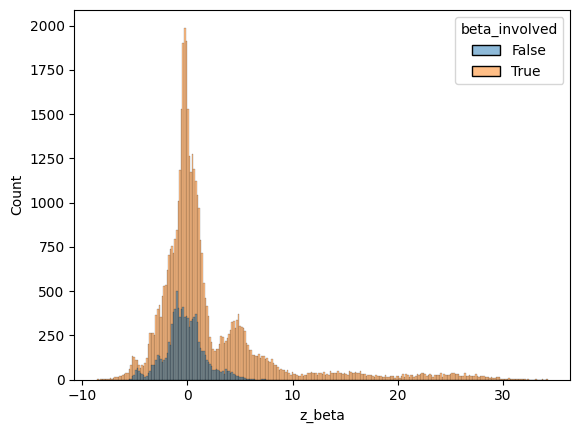

In [50]:
sns.histplot(data=df, x='z_beta', hue='beta_involved')

<Axes: xlabel='period', ylabel='z_beta'>

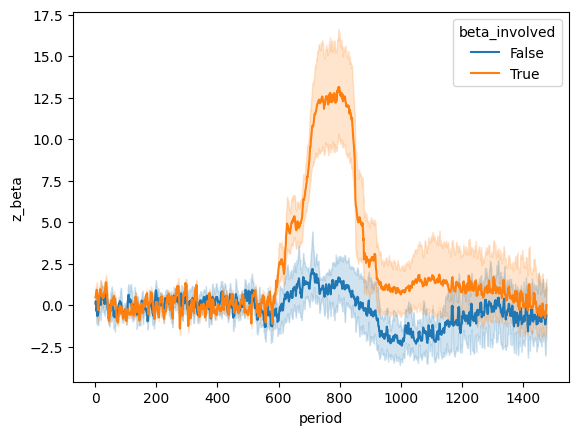

In [52]:
# Quick plot of beta power in SOZ vs NIZ

sns.lineplot(data=df, hue='beta_involved', x='period', y='z_beta')#,palette=COLOR_MAP)
# by the looks of this plot It seems like beta increases drastically in SOZ and then is followed by a a sustained increase in beta in the NIZ
# shortly into the ictal period. Possibly a measure of generalization

<Axes: xlabel='period', ylabel='frac_change_beta'>

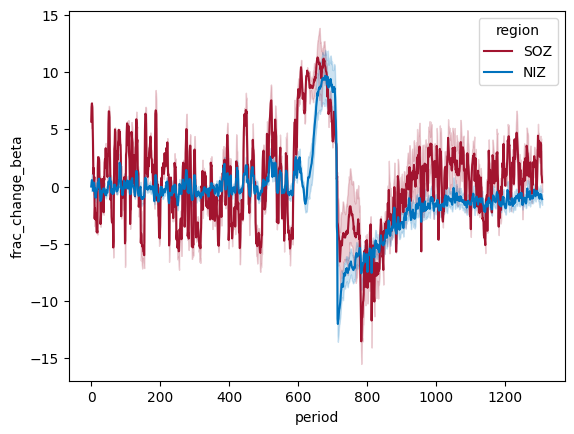

In [12]:
#Comparing fractional change with z_score change in beta. First I notice that the overall shapes are conserved
# SOZ increase is steady plateaus and then dies off at the end of seizures
# Then I notice a spike, a dip and delayed increase in NIZ fractional beta. However, the magnitude of change is much smaller.
# I believe this could be because the soz has a higher distributino of beta power in the interictal period, so the change 
# relative to the mean in absolute terms is similar to the NIZ
# BUT the NIZ has a much tighter distribution of beta values in the interictal period, so even a similar increase in magnitude fractionally
# may appear more drastic relative to the z-scored values
# one way to verify would be to save out STD and mu for both. TODO: consider making this a logged/saved output.
sns.lineplot(data=df, x='period', y='frac_change_beta',hue='region',palette=COLOR_MAP)

In [34]:
#Try to find contacts that don't ever move above 1 std of beta power (z_scored)
df_centered = center_onset(df)
df_ictal = df_centered[df_centered.win_label == "ictal"]

In [ ]:
df

## Delta Power

<Axes: xlabel='period', ylabel='z_delta'>

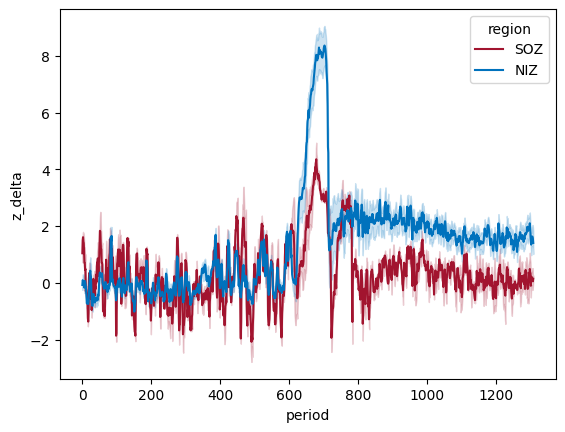

In [13]:
#Examining changes in delta, supposedly the band most associated with default brain oscillations
# AKA the unconscious resting state, also seen in deep sleep
sns.lineplot(data=df, hue='region', x='period', y='z_delta',palette=COLOR_MAP)

<Axes: xlabel='period', ylabel='frac_change_delta'>

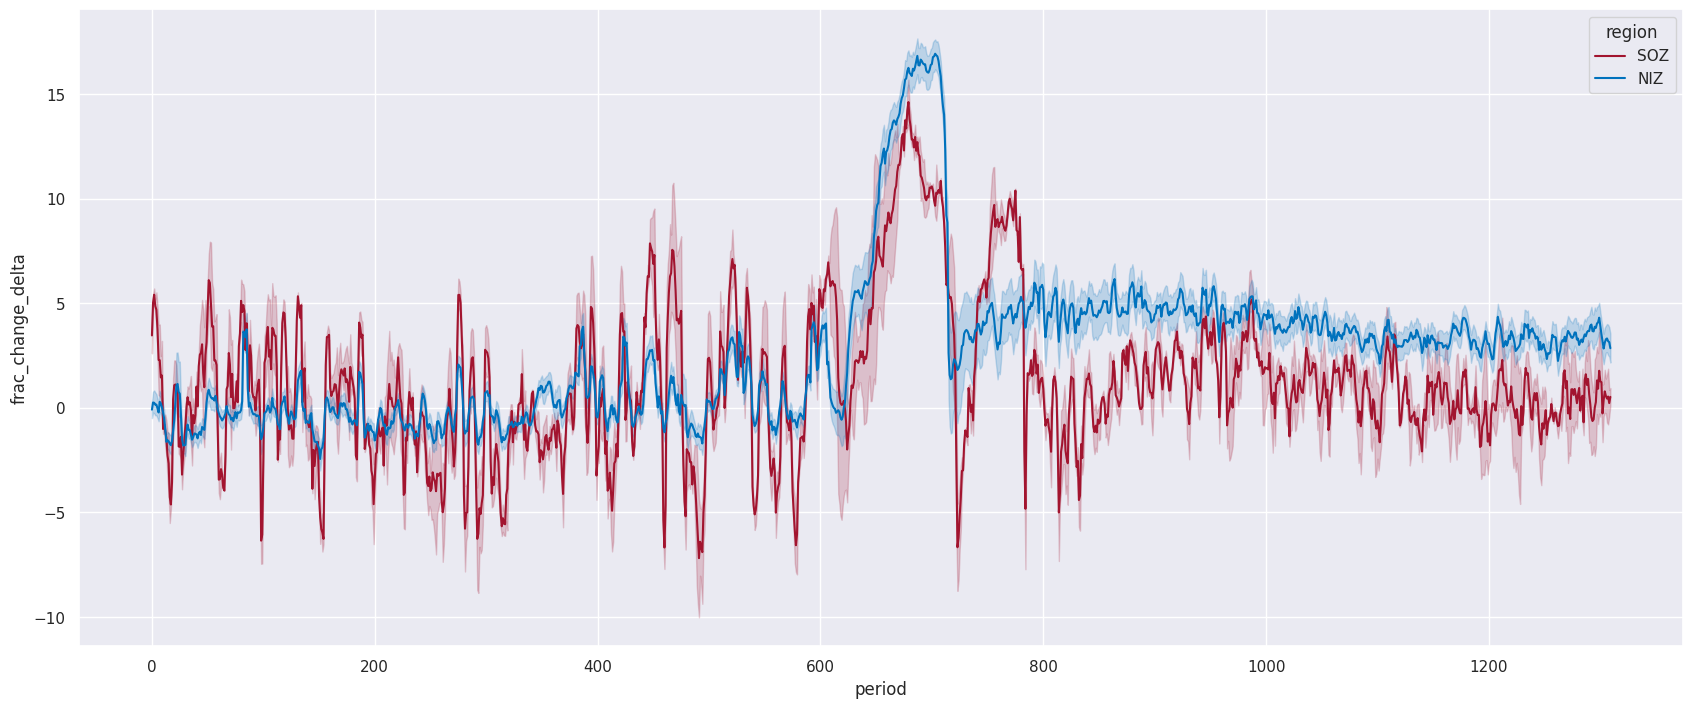

In [53]:
sns.lineplot(data=df, x='period', y='frac_change_delta',hue='region',palette=COLOR_MAP)

<Axes: xlabel='period', ylabel='z_delta'>

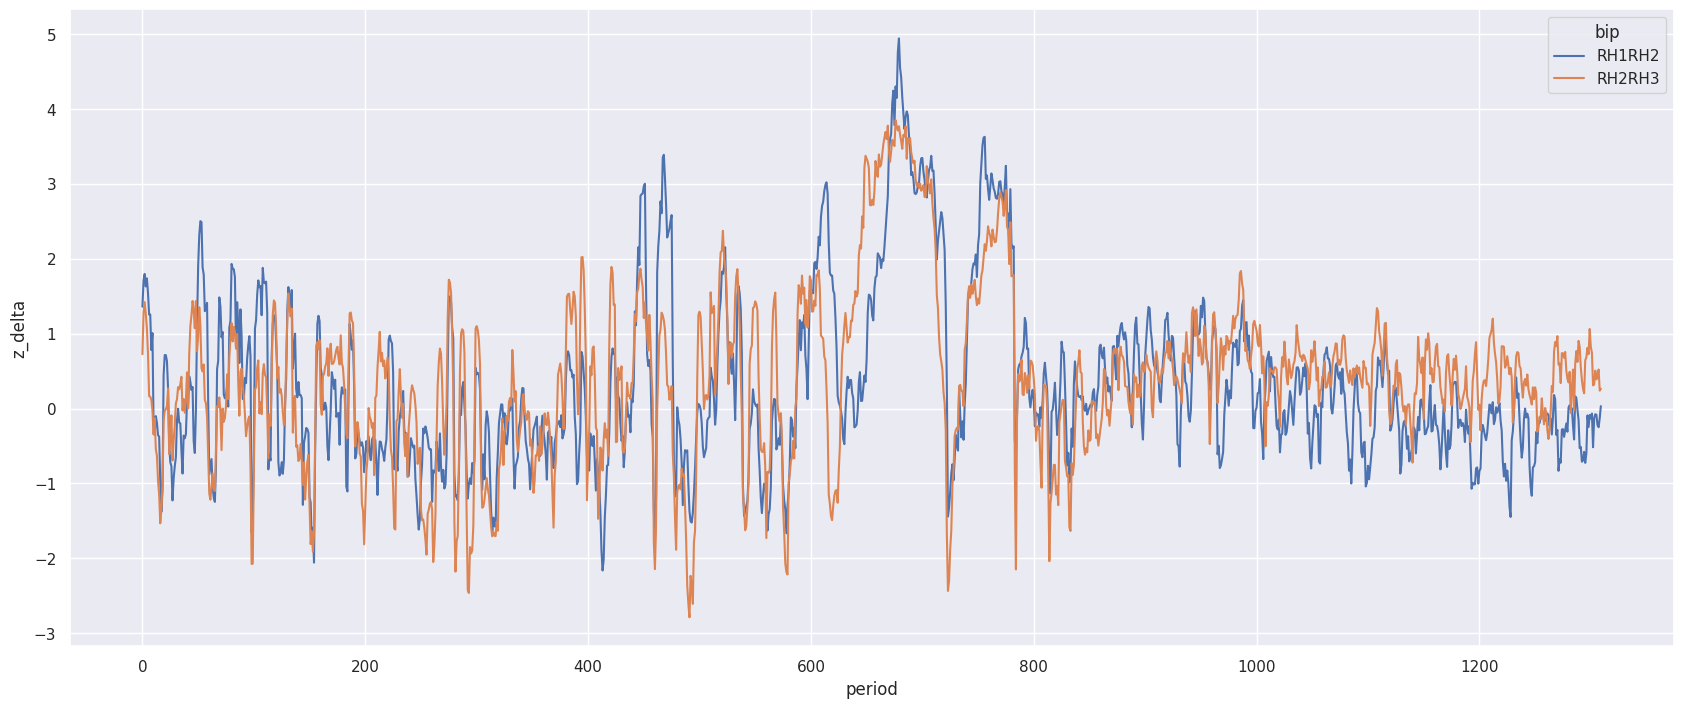

In [54]:

SOZ_df = df[df.region == 'SOZ']

sns.set_theme(rc={'figure.figsize':(20.7,8.27)})
sns.lineplot(data=SOZ_df, hue='bip', x='period', y='z_delta')

<Axes: xlabel='period', ylabel='z_delta'>

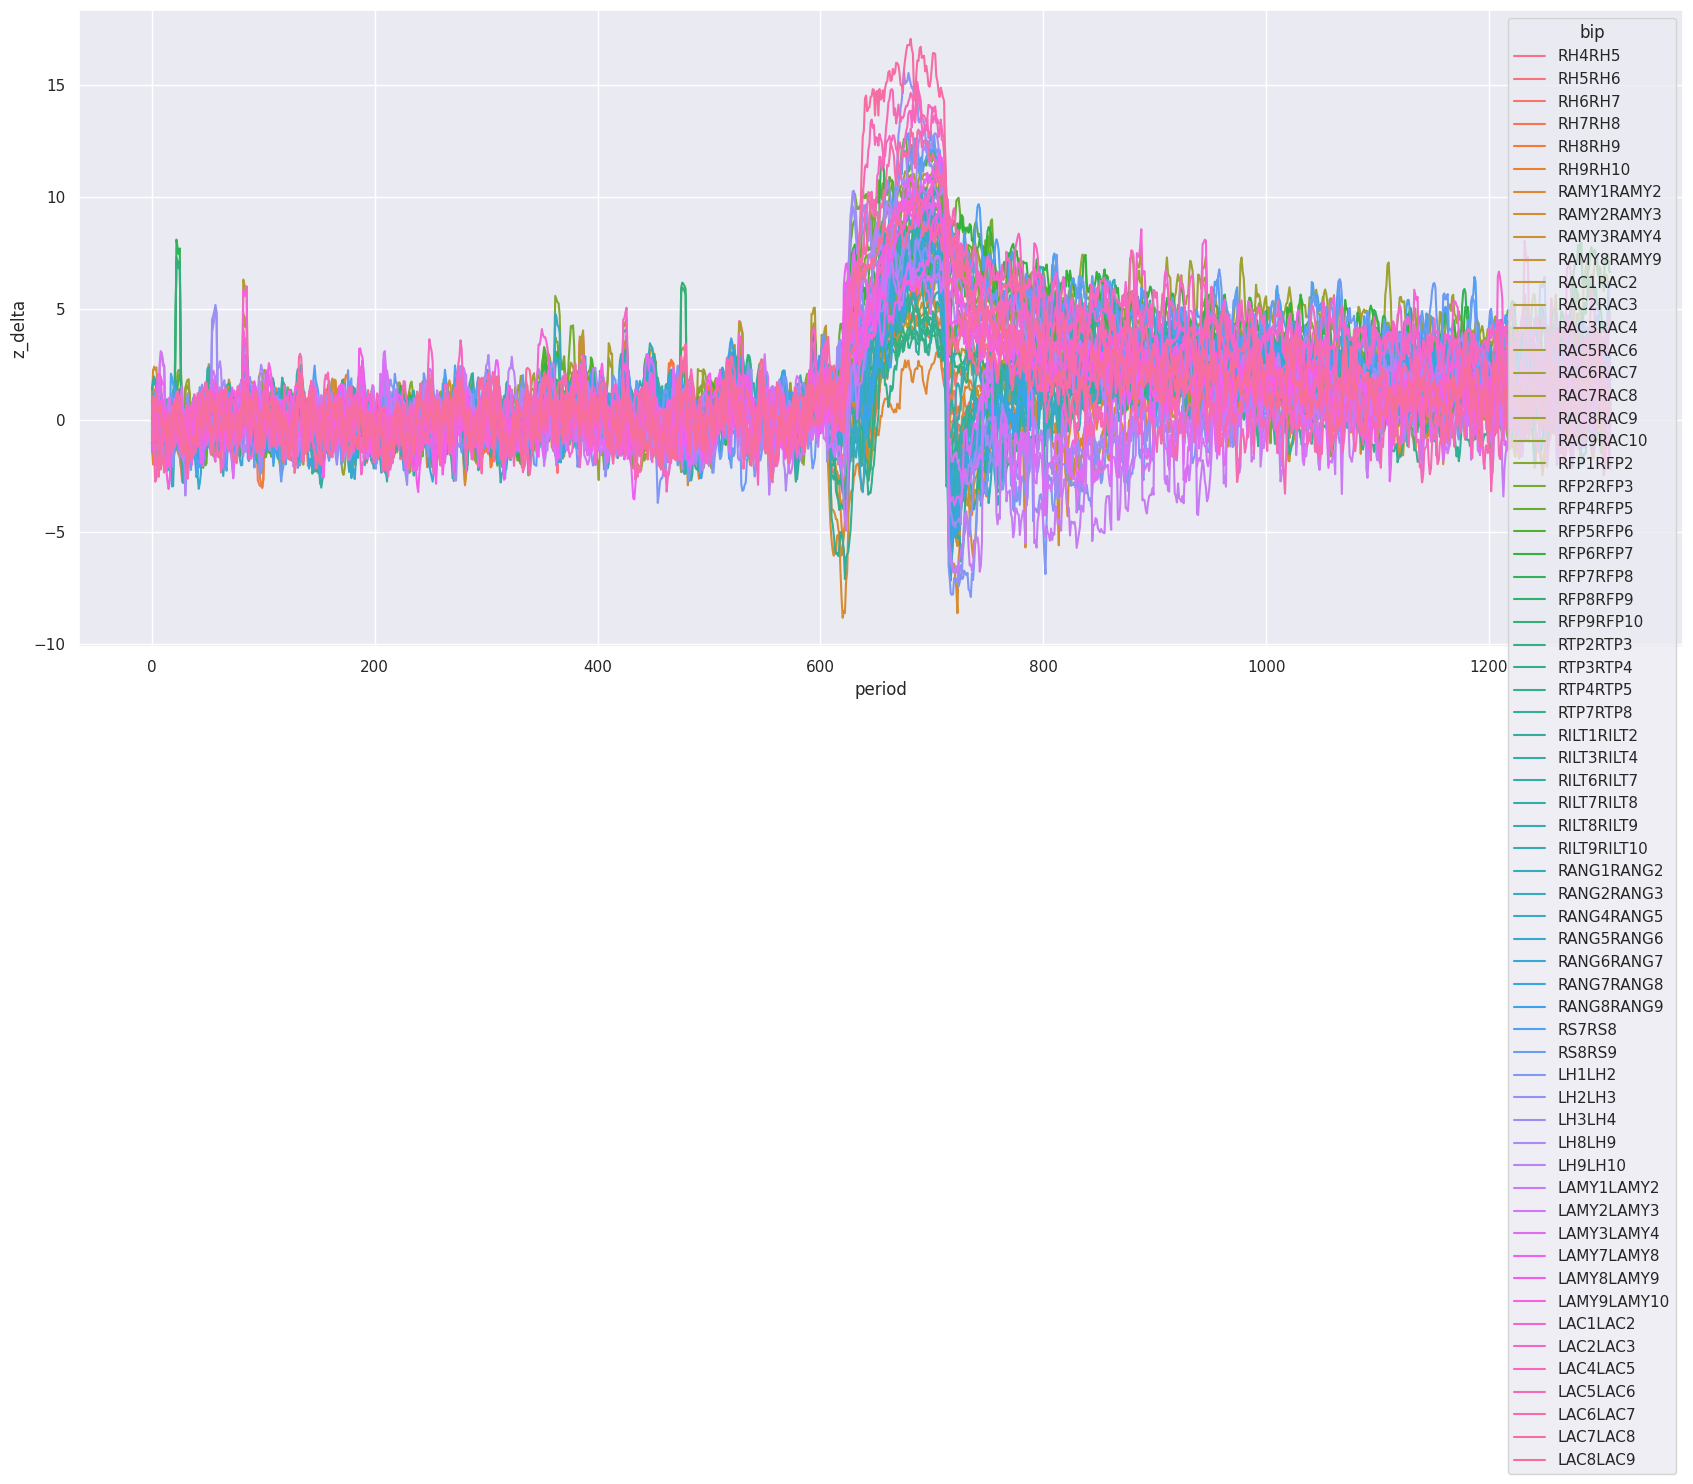

In [55]:
niz_df = df[df.region == 'NIZ']

sns.set_theme(rc={'figure.figsize':(20.7,8.27)})
sns.lineplot(data=niz_df, hue='bip', x='period', y='z_delta')


In [25]:
get_ei_slope(freqs, first_window[50,:])

np.float64(-0.0743445625577473)

In [ ]:
spectral_dfs = gen_global_peri_psd(sub_obj,spectral_keys)

In [ ]:
with sns.plotting_context("paper"):
    sns.lineplot(spectral_dfs, x="freq", y='power', hue='period')
    plt.title("Global PSD per Recording Period for Epat 31 peri-ictal Data FIAS")
    plt.xlabel("Frequency")
    plt.ylabel("log(Power)")
    plt.savefig("../viz/global_psd_Epat31_FIAS.svg",transparent=True)


In [ ]:
sub_obj['pdc']['seizure']['patID']

In [ ]:
for period in set(spectral_dfs.period):
    df = spectral_dfs[spectral_dfs.period == period]
    freqs = df.freq.values.reshape(-1,1)
    power = df.power.values.reshape(-1,1)
    slope = get_ei_slope(freqs, power)
    print(f"Period: {period} \nSlope: {slope}\n")

In [ ]:
len(sub_structs)

In [ ]:
peri_df = gen_patient_psd('Epat31', sub_structs,spectral_keys, 'gen')

In [ ]:
##Should be the same as above

with sns.plotting_context("paper"):
    sns.lineplot(peri_df, x="freq", y='power', hue='period')
    plt.title("Global PSD per Recording Period for Epat 31 peri-ictal Data FIAS")
    plt.xlabel("Frequency")
    plt.ylabel("log(Power)")
    plt.savefig("../viz/global_psd_Epat31_FIAS.svg",transparent=True)

In [ ]:
peri_df = gen_patient_psd('Epat31', sub_structs,spectral_keys, 'channel')

grp_df = peri_df.groupby(["freq",'labels','period']).mean().reset_index()

grp_df.period = grp_df.period.apply(lambda x : x.split("_")[-1])
grp_df

In [ ]:
with sns.plotting_context("paper"):
    with sns.color_palette("flare"):
        grid = sns.FacetGrid(grp_df,col='period',col_order=['interictal','pre','ictal','post']) 
        grid.map_dataframe(sns.lineplot, y='power',x='freq', hue='labels')
        grid.add_legend()
        grid.figure.suptitle("Peri Ictal PSD on a per-contact lvl",y=1.01)
        plt.savefig("../viz/peri_peri_psd.svg",transparent=True)

In [ ]:
contact_label = format_soz(sub_obj['pdc']['seizure']['soz_per_seizure'])
ei_df = get_reg_ei(sub_obj['pdc']['seizure'],spectral_keys,contact_label)
ei_df.period = ei_df.period.apply(lambda x : x.split("_")[-1])


In [ ]:
with sns.plotting_context("paper"):
    with sns.color_palette("flare"):
        grid = sns.FacetGrid(ei_df,col='period',col_order=['interictal','pre','post']) 
        grid.map_dataframe(sns.violinplot, y='e_i',x='region', hue='region')
        grid.add_legend()
        grid.figure.suptitle("Peri Ictal E/I on a per-contact lvl",y=1.01)
        plt.savefig("../viz/peri_E_I_psd.svg",transparent=True)

In [ ]:
sub_list = [sub_path.split("/")[-2] for sub_path in sub_paths]
sz_list = [sub_path.split("/")[-1].split("_")[-2] for sub_path in sub_paths]

In [ ]:
sub_paths= glob.glob(os.path.join(DATA_DIR, "*pat*", "*.mat"))


In [ ]:
# from tqdm.notebook import tqdm
# sub_paths= glob.glob(os.path.join(DATA_DIR, "*pat*", "*.mat"))
# num_cores = 20
# ei_dfs = []
# count = 0
# for f_paths in tqdm(chunker(sub_paths, num_cores)):
#     structs = load_structs(f_paths,num_cores)
#     incl_inds = [i for i in range(len(structs)) if structs[i] != None]
#     structs = [structs[i] for i in incl_inds]

#     sub_list = [sub_path.split("/")[-2] for sub_path in f_paths]
#     sub_list = [sub_list[i] for i in incl_inds] #NOTE: god this is messy. TODO: fix struct chars for ID and sztype
#     sz_list = [sub_path.split("/")[-1].split("_")[-2] for sub_path in f_paths]
#     sz_list = [sz_list[i] for i in incl_inds]

#     res_dfs = get_reg_ei_para(structs, sub_list, sz_list, cores=num_cores)
#     ei_dfs.append(res_dfs)
#     count += 1
#     if count >5:
#         break
# ei_dfs = pd.concat(ei_dfs)


## Comparing E/I Distributions 

In [5]:
DATA_DIR = '/mnt/ernie_main/Ghassan/ephys/data/ei_bal/'
ei_files = glob.glob(os.path.join(DATA_DIR, "ei_bal_*pat*.csv"))
print(f"Total of {len(ei_files)} to load")


Total of 43 to load


In [6]:
ei_dfs = []
for f in ei_files:
    df = pd.read_csv(f).rename(columns={"window_designation":"window_designations"})
    df = center_onset(df)
    ei_dfs.append(df)
#should drop any of the mid-seizure periods that were not sampled and whole events that 
# were not able to be centered
ei_dfs = pd.concat(ei_dfs).dropna()
print(f"Successfully loaded and centered {len(set(ei_dfs.patID))}")

/home/ghassan/Documents/Research/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:624: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_df['win_sz_centered'] = center_windows(event_df.window_designations, event_df.period.values,center_designations=center_designations)
/home/ghassan/Documents/Research/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_df['sz_end'] = get_sz_end(event_df)
/home/ghassan/Documents/Research/Ephys/Code/dynamic_ISH/c

Successfully loaded and centered 42


In [7]:
ei_dfs = ei_dfs.dropna()

In [8]:
def resample_regions(res_df, reg_col):
    channel_counts = Counter(res_df[reg_col])
    n_samps = min(channel_counts.values())
    pz_df = res_df[res_df[reg_col] == 'PZ'].sample(n=n_samps, replace=True)

    soz_df = res_df[res_df[reg_col] == 'SOZ'].sample(n=n_samps, replace=True)

    niz_df = res_df[res_df[reg_col] == 'NIZ'].sample(n=n_samps, replace=True)

    return pd.concat([pz_df, soz_df, niz_df])

def get_stats_df(res_df, grouping_col='win_label'):
    stats_df = pd.DataFrame(columns=['p_val',grouping_col])
    for i, period in enumerate(set(res_df[grouping_col])):
        per_df = res_df[res_df[grouping_col] == period]
        a = per_df[per_df.region == 'PZ'].e_i
        b = per_df[per_df.region == 'SOZ'].e_i
        c = per_df[per_df.region == 'NIZ'].e_i
        F, p = f_oneway(a, b, c)
        stats_df.loc[i] = [p, period]

    return stats_df

In [9]:
#stats_df.groupby('period').mean()
ei_dfs = ei_dfs.dropna()
set(ei_dfs.win_label)

{'early_ictal',
 'early_post_ictal',
 'ictal',
 'interictal',
 'late_ictal',
 'post_ictal',
 'pre_ictal'}

In [11]:
stats_df = []
run_count = 0
for i in range(10):
    resamp_dfs = resample_regions(ei_dfs, 'region')
    grp_df= resamp_dfs[['e_i', 'region', 'win_label','patID']].groupby(['patID','region','win_label']).mean().reset_index()
 #   grp_df.period = grp_df.period.apply(lambda x : x.split("_")[-1])
    run_count +=1
    df = get_stats_df(grp_df)
    df['run'] = run_count
    stats_df.append(df)
stats_df = pd.concat(stats_df)


In [26]:
stats_df.groupby('win_label').mean()

p_val    run
win_label                        
early_ictal       0.694300  500.5
early_post_ictal  0.491998  500.5
ictal             0.008464  500.5
interictal        0.047403  500.5
late_ictal        0.078623  500.5
post_ictal        0.739496  500.5
pre_ictal         0.152888  500.5

In [10]:

# with sns.plotting_context("paper"):
#     with sns.color_palette("flare"):
#         grid = sns.FacetGrid(grp_df,col='win_label',col_order=['interictal', 'pre_ictal','early_ictal','ictal','late_ictal','early_post_ictal','post_ictal']) 
#         grid.map_dataframe(sns.violinplot, y='e_i',x='region', hue='region')
#         grid.add_legend()
#         grid.set_ylabels("Excitation Inhibition")
#         grid.figure.suptitle("Peri Ictal E/I on a per-contact lvl",y=1.01)
#         plt.savefig("../viz/peri_full_E_I_psd.svg",transparent=True)

In [12]:
resamp_dfs

e_i region  period window_designations   patID  \
93938   -0.065538     PZ    1043         2.0_2.0_2.0  Epat30   
80335   -0.055092     PZ     694         2.0_2.0_2.0  Spat13   
4511087 -0.046635     PZ    1220         2.0_2.0_2.0  Epat26   
404888  -0.062920     PZ     140         0.0_0.0_0.0  Epat26   
3293732 -0.112956     PZ    1063         2.0_2.0_2.0  Epat26   
...           ...    ...     ...                 ...     ...   
16328   -0.026187    NIZ     173         0.0_0.0_0.0  Epat21   
150512  -0.034776    NIZ     698         2.0_2.0_2.0  Spat06   
181207  -0.084689    NIZ    1264         2.0_2.0_2.0  Epat19   
109702  -0.085339    NIZ     937         2.0_2.0_2.0  Epat24   
515914  -0.036345    NIZ    1218         2.0_2.0_2.0  Epat26   

                          sz_type eventID  win_sz_centered  sz_end  \
93938                        FBTC       1            448.0   137.0   
80335    Focal, unknown awareness       2             99.0    32.0   
4511087                      FIAS       9            625.0    97.0   
404888                        FAS      15           -455.0   105.0   
3293732                      FIAS      44            468.0   101.0   
...                           ...     ...              ...     ...   
16328                        FIAS       1           -422.0   101.0   
150512   Focal, unknown awareness       2            103.0    74.0   
181207                        FAS       1            669.0   125.0   
109702                       FBTC      16            342.0   193.0   
515914                        FAS      15            623.0   105.0   

         win_sz_st_end         win_label  
93938            340.0        post_ictal  
80335             93.0        post_ictal  
4511087          557.0        post_ictal  
404888          -455.0        interictal  
3293732          396.0        post_ictal  
...                ...               ...  
16328           -422.0        interictal  
150512            58.0  early_post_ictal  
181207           571.0        post_ictal  
109702           176.0        post_ictal  
515914           547.0        post_ictal  

[4723566 rows x 11 columns]

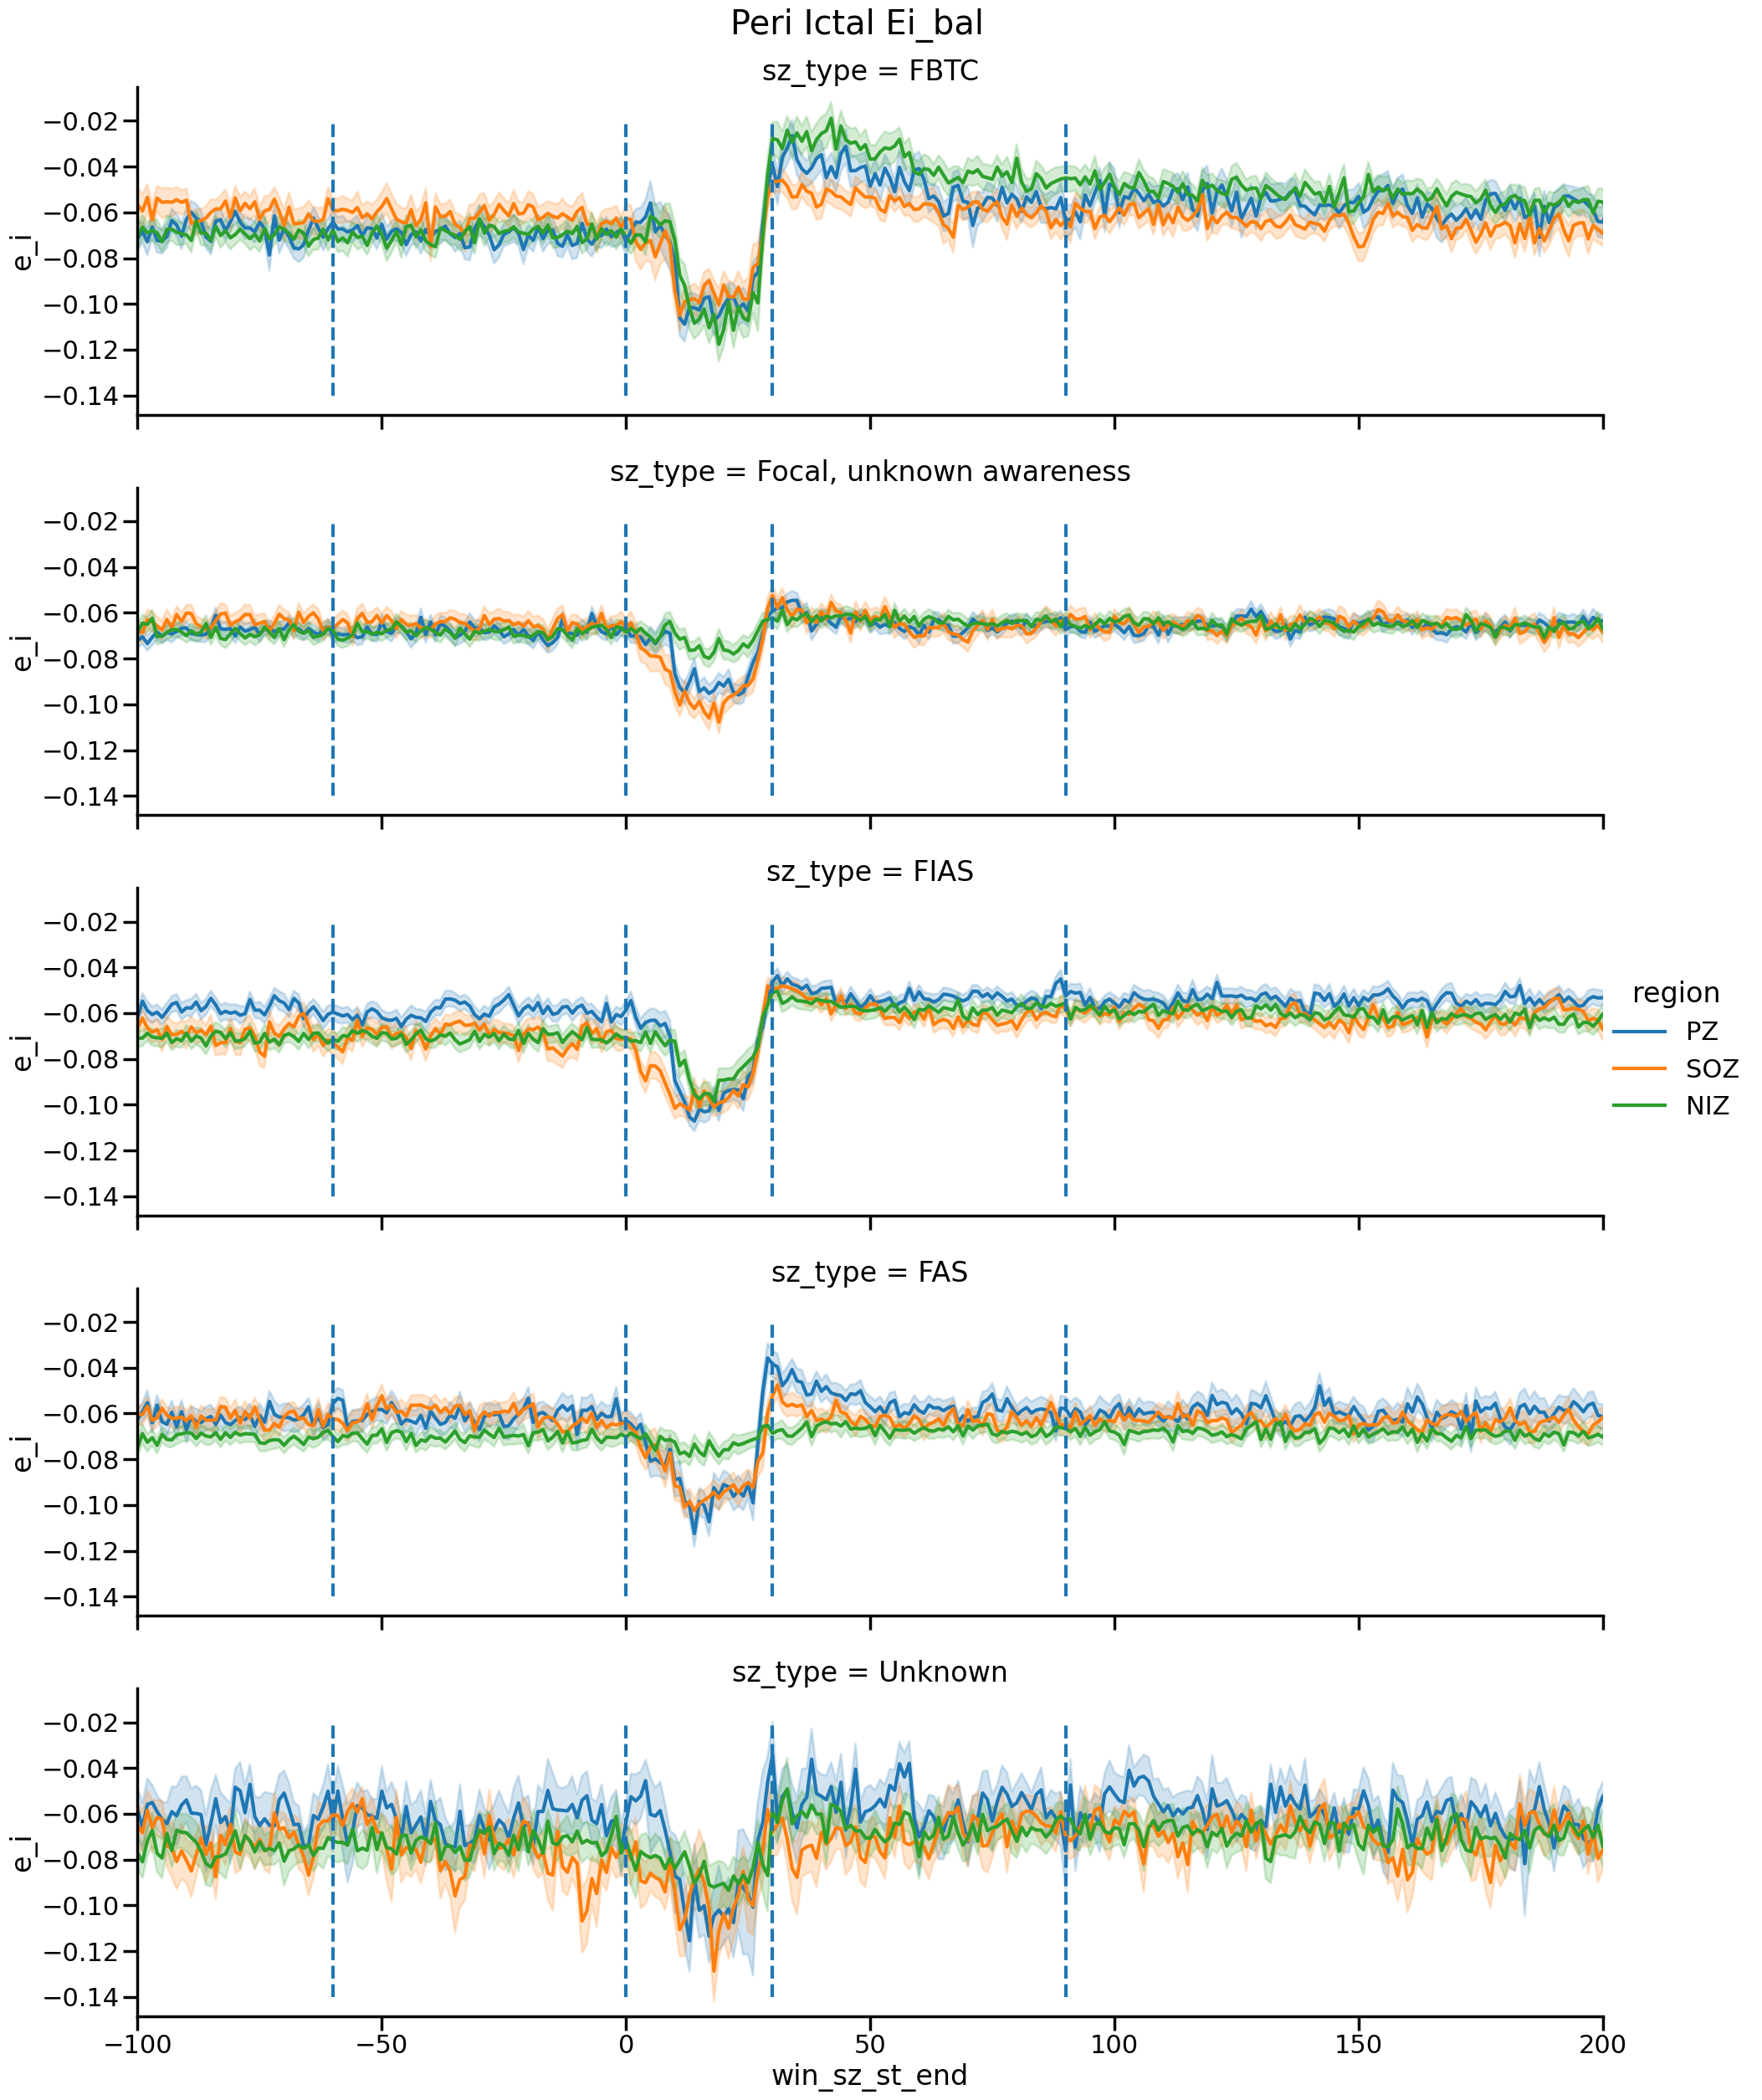

In [15]:
with sns.plotting_context("poster"):
    with sns.color_palette("tab10"):
        plot_df = resamp_dfs.dropna()
        #grid = sns.FacetGrid(plot_df, row='sz_type',aspect=4) 
        grid = sns.relplot(data= plot_df,
                           x='win_sz_st_end',
                           y="e_i",
                           row='sz_type',
                           hue='region',
                           aspect=4,
                           kind='line')
 #       grid.map_dataframe(sns.lineplot, y='e_i',x='win_sz_st_end', hue='region')
        #grid.add_legend()
        axes = grid.axes
        for ax in axes:
            ax[0].vlines(x = [-60,0, 30, 90], ymin = -.14, ymax = -.02,linestyles ='dashed')
        plt.xlim(-100, 200)
        grid.figure.suptitle("Peri Ictal Ei_bal",y=1.01)
        plt.savefig("../viz/peri_Epat_FULL_ei_bal.pdf",transparent=True)

In [ ]:
grp_df[['region','period','e_i']].groupby(['region','period']).mean()